# Setup

In [60]:
import matplotlib.pyplot as plt
from math import floor

import numpy as np
import scipy.io as sio

import glob
import os
import re

from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import cross_val_score

plt.rcParams['figure.figsize'] = [15, 5]
%matplotlib inline

## Data

In [5]:
data_binarised_file = "../data/processed/fly_data_binarised"
data_binarised = np.load(data_binarised_file + ".npy")

In [6]:
data_binarised.shape

(2250, 15, 8, 13, 2)

In [7]:
n_samples, n_channels, n_trials, n_flies, n_conds = data_binarised.shape

## Utility Functions

In [11]:
def extract_value(data, i_result, field):
    """ Extracts a value from the ch_group_results data structure.
    
    Args:
        data: The processed data structure from sio.loadmat[data_field]
        i_result: The index of the result in the data structure.
        field: A string, which must be one of:
            - "state_phis"
            - "tpm"
            - "state_counts"
            - "i_trial"
            - "i_fly"
            - "i_cond"
            - "channels"
            - "all"
    
    Returns:
        A np.ndarray of the extracted data.
    
    """
    
    if field == "state_phis" or field == "channels" or field == "state_counts":
        return data[0, i_result][0, 0][field].flatten()
    elif field == "i_trial" or field == "i_cond" or field == "i_fly":
        return data[0, i_result][0, 0][field][0, 0]
    elif field == "tpm":
        return data[0, i_result][0, 0][field]
    elif field == "all":
        return data[0, i_result][0, 0]
    else:
        raise ValueError("Field not recognised in input data.")

# Decoding

## Across-Trials, Within-Fly, Across-Channel Groups

This will give us 1 classification score for each fly (for each method).

Each classification set will have `n_trials * n_conds = 16` samples. Each sample will have a multidimensional independent variable, with the number of dimensions equalling the number of channel groups.

In [23]:
decoding_results = []

glob_str_all = "../data/processed/phis/PHI_*.mat"

ch_nums = set(map(lambda x: int(re.search(r"PHI_(\d+)", x).group(1)), glob.glob(glob_str_all)))

# n_flies, n_trials and n_cond should have been defined beforehand but if not:
#n_flies = 13
#n_trials = 8
#n_cond = 2

for ch_num in ch_nums:

    glob_str_ch_num = "../data/processed/phis/PHI_{}_*.mat".format(ch_num)
    file_ch_num = glob.glob(glob_str_ch_num)
    
    methods = set(map(lambda x: re.search(r"METHOD_(.*?)_", x).group(1), file_ch_num))
    
    n_results = n_flies * n_trials * n_conds
    
    for method in methods:
        glob_str_file = "../data/processed/phis/PHI_{}_METHOD_{}*.mat".format(ch_num, method)
        file_list = glob.glob(glob_str_file)

        pooled_xs = np.zeros((n_flies, n_results // n_flies, len(file_list)))
        # Note ys should be the same across all files for a particular channel number

        ys_all = np.zeros(n_results // n_flies)

        for i_f, filename in enumerate(file_list):

            file_results = sio.loadmat(filename)
            data = file_results["ch_group_results"]

            for i_fly in range(n_flies):

                xs_all = np.zeros(n_results // n_flies)

                i_res = 0
                for i_r in range(n_results):
                    if extract_value(data, i_r, "i_fly") == i_fly:
                        phis = extract_value(data, i_r, "state_phis")
                        counts = extract_value(data, i_r, "state_counts")
                        weighted_phi = (phis * (counts / counts.sum())).sum()
                        xs_all[i_res] = weighted_phi
                        if i_f == 0: # run this only once per method
                            ys_all[i_res] = extract_value(data, i_r, "i_cond")
                        i_res += 1

                pooled_xs[i_fly, :, i_f] = xs_all

        for i_fly in range(n_flies):

            model = NearestCentroid()
            scores = cross_val_score(model, pooled_xs[i_fly, :, :], ys_all, cv=3)

            decoding_result = {}

            decoding_result["i_fly"] = i_fly
            decoding_result["score_mean"] = scores.mean()
            decoding_result["score_std"] = scores.std()
            decoding_result["method"] = method
            decoding_result["ch_num"] = ch_num

            decoding_results.append(decoding_result)

In [62]:
decoding_results[0:4]

[{'i_fly': 0,
  'score_mean': 0.75,
  'score_std': 0.0680413817439772,
  'method': 'logistic2',
  'ch_num': 2},
 {'i_fly': 1,
  'score_mean': 0.8611111111111112,
  'score_std': 0.10393492741038726,
  'method': 'logistic2',
  'ch_num': 2},
 {'i_fly': 2,
  'score_mean': 0.9444444444444445,
  'score_std': 0.0785674201318386,
  'method': 'logistic2',
  'ch_num': 2},
 {'i_fly': 3,
  'score_mean': 0.6944444444444445,
  'score_std': 0.14163943093313291,
  'method': 'logistic2',
  'ch_num': 2}]

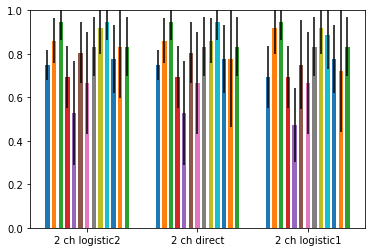

In [63]:
#colors = ["red", "blue", "green"]

n_methods = len(decoding_results) // n_flies

w = 0.04

mid_fly = n_flies // 2

for i_fly in range(n_flies):
    r_fly = [r for r in decoding_results if r.get("i_fly") == i_fly]
    x_pos = list(map(lambda x: x + ((i_fly - mid_fly) * (w*1.5)), range(n_methods)))
    heights = [r.get("score_mean") for r in r_fly]
    if i_fly == mid_fly:
        tick_labels = ["{} ch {}".format(r.get("ch_num"), r.get("method")) for r in r_fly]
    else:
        tick_labels = None
    plt.bar(x_pos,
            heights,
            width = w,
            tick_label = tick_labels,
            #color = [colors[r.get("ch_num") - 2] for r in r_fly],
            yerr = [r.get("score_std") for r in r_fly])
    plt.ylim((0, 1))

## Across-Trials, Across-Flies, Across-Channel Groups

This will give us 1 classification score (for each method).

Each classification set will have `n_trials * n_conds = 208` samples. Each sample will have a multidimensional independent variable, with the number of dimensions equalling the number of channel groups.

In [12]:
decoding_results = []

glob_str_all = "../data/processed/phis/PHI_*.mat"

ch_nums = set(map(lambda x: int(re.search(r"PHI_(\d+)", x).group(1)), glob.glob(glob_str_all)))

# n_flies, n_trials and n_cond should have been defined beforehand but if not:
#n_flies = 13
#n_trials = 8
#n_cond = 2

for ch_num in ch_nums:

    glob_str_ch_num = "../data/processed/phis/PHI_{}_*.mat".format(ch_num)
    file_ch_num = glob.glob(glob_str_ch_num)
    
    methods = set(map(lambda x: re.search(r"METHOD_(.*?)_", x).group(1), file_ch_num))
    
    n_results = n_flies * n_trials * n_conds

    for method in methods:
        glob_str_file = "../data/processed/phis/PHI_{}_METHOD_{}*.mat".format(ch_num, method)
        file_list = glob.glob(glob_str_file)
        
        pooled_xs = np.zeros((n_results, len(file_list)))
        # Note ys should be the same across all files for a particular channel number
        
        ys_all = np.zeros(n_results)
                
        for i_f, filename in enumerate(file_list):

            file_results = sio.loadmat(filename)
            data = file_results["ch_group_results"]

            xs_all = np.zeros(n_results)

            for i_r in range(n_results):
                phis = extract_value(data, i_r, "state_phis")
                counts = extract_value(data, i_r, "state_counts")
                weighted_phi = (phis * (counts / counts.sum())).sum()
                xs_all[i_r] = weighted_phi
                if i_f == 0:
                    ys_all[i_r] = extract_value(data, i_r, "i_cond")
            
            pooled_xs[:, i_f] = xs_all

        model = NearestCentroid()
        scores = cross_val_score(model, pooled_xs, ys_all, cv=5)

        decoding_result = {}

        decoding_result["score_mean"] = scores.mean()
        decoding_result["score_std"] = scores.std()
        decoding_result["method"] = method
        decoding_result["ch_num"] = ch_num

        decoding_results.append(decoding_result)

/Users/wjmn/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/wjmn/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/wjmn/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [13]:
decoding_results

[{'score_mean': 0.6205882352941177,
  'score_std': 0.05499656001379745,
  'method': 'logistic2',
  'ch_num': 2},
 {'score_mean': 0.6253501400560224,
  'score_std': 0.048266727347384394,
  'method': 'direct',
  'ch_num': 2},
 {'score_mean': 0.6394957983193277,
  'score_std': 0.029646919084765022,
  'method': 'logistic1',
  'ch_num': 2}]

(0, 1)

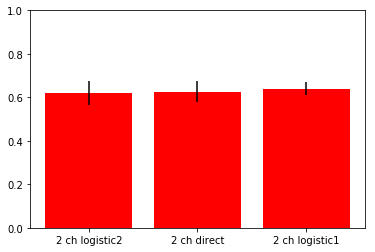

In [14]:
colors = ["red", "blue", "green"]

plt.bar(range(len(decoding_results)),
        [r.get("score_mean") for r in decoding_results],
        tick_label = ["{} ch {}".format(r.get("ch_num"), r.get("method")) for r in decoding_results],
        color = [colors[r.get("ch_num") - 2] for r in decoding_results],
        yerr = [r.get("score_std") for r in decoding_results])
plt.ylim((0, 1))